In [1]:
# --- STEP 1: Total Setup ---

print(" Force-Reinstalling Core Stack...")
# We force reinstall numpy, scipy, pandas, and matplotlib to ensure they all match
!pip install --force-reinstall "numpy<2" "scipy<1.13" "pandas<2.2" "matplotlib<3.8" > /dev/null

print(" Installing PyTorch 2.2.0 (CUDA)...")
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121 > /dev/null

print(" Installing NLP Tools...")
!pip install torchtext==0.17.0 transformers==4.38.2 datasets scikit-learn portalocker spacy > /dev/null

print(" Downloading Spacy Models...")
!python -m spacy download en_core_web_sm > /dev/null
!python -m spacy download de_core_news_sm > /dev/null

# Install torchmetrics for ROUGE calculation
!pip install torchmetrics > /dev/null
# Fix PIL/Pillow version conflict
!pip install "Pillow<10.0.0"
print(" TorchMetrics installed.")

print("\n Setup Complete.")

 Force-Reinstalling Core Stack...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2025.10.0 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires tornado==6.4.2, 

In [2]:
# Step 1.5 Force reinstall scipy to resolve the NumPy binary incompatibility
print("Fixing SciPy binary incompatibility...")
!pip install --force-reinstall "scipy<1.13"

# --- Search and Destroy Cupy ---
import subprocess
import sys
# 1. Find the exact package name
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==')[0] for r in reqs.split()]
cupy_packages = [pkg for pkg in installed_packages if 'cupy' in pkg]

print(f"Found Cupy packages: {cupy_packages}")

# 2. Uninstall them
for pkg in cupy_packages:
    print(f"Uninstalling {pkg}...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'uninstall', '-y', pkg])

print(" Cupy cleanup complete.")
print(" Fix complete.")

Fixing SciPy binary incompatibility...
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not i

In [3]:
# --- STEP 2: Data Pipeline for Machine Translation ---
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy.cli

#  Verify Spacy Models
print("0. Verifying Spacy Models...")
try:
    spacy.load("en_core_web_sm")
except OSError:
    print("    English model missing. Downloading...")
    spacy.cli.download("en_core_web_sm")

try:
    spacy.load("de_core_news_sm")
except OSError:
    print("    German model missing. Downloading...")
    spacy.cli.download("de_core_news_sm")
print("    Spacy Models Ready.")

#  Load Multi30k Dataset
print("1. Loading Multi30k (En-De) dataset...")
dataset = load_dataset("bentrevett/multi30k")
train_data = list(dataset['train'])
val_data = list(dataset['validation'])
test_data = list(dataset['test'])
print(f"   Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

#  Define Tokenizers
print("2. Setting up Spacy Tokenizers...")
tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')

#  Build Vocabularies
print("3. Building Vocabularies...")
def yield_tokens(data_iter, language):
    tokenizer = tokenizer_de if language == 'de' else tokenizer_en
    for item in data_iter:
        yield tokenizer(item[language])

specials = ["<unk>", "<pad>", "<bos>", "<eos>"]

vocab_src = build_vocab_from_iterator(yield_tokens(train_data, 'de'), specials=specials, min_freq=2)
vocab_tgt = build_vocab_from_iterator(yield_tokens(train_data, 'en'), specials=specials, min_freq=2)

vocab_src.set_default_index(vocab_src["<unk>"])
vocab_tgt.set_default_index(vocab_tgt["<unk>"])

print(f"   German (Source) Vocab Size: {len(vocab_src)}")
print(f"   English (Target) Vocab Size: {len(vocab_tgt)}")

#  Collate Function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BOS_IDX = vocab_src['<bos>']
EOS_IDX = vocab_src['<eos>']
PAD_IDX = vocab_src['<pad>']

TGT_BOS_IDX = vocab_tgt['<bos>']
TGT_EOS_IDX = vocab_tgt['<eos>']
TGT_PAD_IDX = vocab_tgt['<pad>']

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for item in batch:
        src_tokens = [vocab_src[token] for token in tokenizer_de(item['de'])]
        src_tensor = torch.tensor([BOS_IDX] + src_tokens + [EOS_IDX], dtype=torch.long)
        src_batch.append(src_tensor)
        
        tgt_tokens = [vocab_tgt[token] for token in tokenizer_en(item['en'])]
        tgt_tensor = torch.tensor([TGT_BOS_IDX] + tgt_tokens + [TGT_EOS_IDX], dtype=torch.long)
        tgt_batch.append(tgt_tensor)
        
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=TGT_PAD_IDX)
    
    return src_batch.to(device), tgt_batch.to(device)

#  Create DataLoaders
print("4. Creating DataLoaders...")
BATCH_SIZE = 128

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(" Data Pipeline Complete.")

0. Verifying Spacy Models...
    Spacy Models Ready.
1. Loading Multi30k (En-De) dataset...


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

   Train: 29000 | Val: 1014 | Test: 1000
2. Setting up Spacy Tokenizers...
3. Building Vocabularies...
   German (Source) Vocab Size: 8014
   English (Target) Vocab Size: 6191
4. Creating DataLoaders...
 Data Pipeline Complete.


In [4]:
# --- STEP 3 : Attention Logic ---
import torch.nn as nn
import torch.nn.functional as F
import random

# 1. Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

# 2. Attention 
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, method="additive"):
        super().__init__()
        self.method = method
        
        if method == "additive":
            self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
            self.v = nn.Linear(dec_hid_dim, 1, bias=False)
            
        elif method == "multiplicative":
            self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
            
        elif method == "dot":
            if (enc_hid_dim * 2) != dec_hid_dim:
                self.project = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
            else:
                self.project = None
        else:
            raise ValueError(f"Unknown attention method: {method}")

    def forward(self, hidden, encoder_outputs):
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) 
        
        attention = None
        
        if self.method == "additive":
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = torch.tanh(self.attn(combined))
            attention = self.v(energy).squeeze(2)
            
        elif self.method == "multiplicative":

            projected_enc = self.attn(encoder_outputs)
            hidden_usq = hidden.unsqueeze(1)
            score = torch.bmm(hidden_usq, projected_enc.permute(0, 2, 1))
            attention = score.squeeze(1)
            
        elif self.method == "dot":
            # Handle dimension mismatch if needed
            if hasattr(self, 'project') and self.project is not None:
                encoder_outputs = self.project(encoder_outputs)
            
            # hidden: [batch, 1, dec_hid]
            hidden_usq = hidden.unsqueeze(1)
            
            # Score = h_dec * h_enc^T
            score = torch.bmm(hidden_usq, encoder_outputs.permute(0, 2, 1))
            
            # Scale
            d_k = encoder_outputs.shape[-1]
            attention = score.squeeze(1) / (d_k ** 0.5)
            
        return F.softmax(attention, dim=1)

#  Decoder 
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        
        # Attention expects [batch, dec_hid], GRU returns [1, batch, dec_hid]
        # So we squeeze the 0th dim for attention
        a = self.attention(hidden.squeeze(0), encoder_outputs)
        a = a.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        
        return prediction, hidden, a.squeeze(1)

# Seq2Seq 
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        
        # Prepare hidden state for decoder [1, batch, hid]
        hidden = hidden.unsqueeze(0)
        
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
            
        return outputs

print(" Architecture Fixed (Multiplicative/Dot Support Added).")

 Architecture Fixed (Multiplicative/Dot Support Added).


In [5]:
# --- STEP 4: Training, Evaluation, and Utils ---
import time
import math

#  Weight Initialization
# Seq2Seq models are sensitive. This helps them start learning immediately.
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

#  Training Function
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):
        # src: [src len, batch size]
        # trg: [trg len, batch size]
        
        optimizer.zero_grad()
        
        # Forward pass
        # output: [trg len, batch size, output dim]
        output = model(src, trg)
        
        # Reshape for loss calculation
        # trg[1:]: exclude <bos> token
        # output[1:]: exclude first output (which corresponds to <bos>)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#  Evaluation Function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            # Turn off teacher forcing for evaluation
            output = model(src, trg, teacher_forcing_ratio=0) 

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#  Timing Helper
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

print("Training functions defined.")

Training functions defined.


In [6]:
# --- STEP 5: Train Model 1 (Additive / Bahdanau) ---
import math

# Hyperparameters 
INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_tgt)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512  
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_EPOCHS = 10
CLIP = 1

# 1. Initialize Model (Additive)
print("Initializing Additive Attention Model...")
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, method="additive")
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model_additive = Seq2Seq(enc, dec, device).to(device)

# 2. Init Weights
model_additive.apply(init_weights)

# 3. Optimizer & Loss
optimizer = torch.optim.Adam(model_additive.parameters())
TRG_PAD_IDX = vocab_tgt['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

print(f"Model Parameters: {sum(p.numel() for p in model_additive.parameters() if p.requires_grad):,}")

# 4. Training Loop
best_valid_loss = float('inf')
print(f"\n---  Starting Additive Attention Training ({N_EPOCHS} Epochs) ---")

history_additive = {'train_ppl': [], 'val_ppl': []}

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model_additive, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_additive, val_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_additive.state_dict(), 'model_additive.pt')
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    history_additive['train_ppl'].append(train_ppl)
    history_additive['val_ppl'].append(valid_ppl)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:.3f}')

print("--- Additive Model Training Complete ---")

Initializing Additive Attention Model...


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Model Parameters: 21,170,223

---  Starting Additive Attention Training (10 Epochs) ---
Epoch: 01 | Time: 1m 26s
	Train Loss: 4.960 | Train PPL: 142.590
	 Val. Loss: 4.686 |  Val. PPL: 108.454
Epoch: 02 | Time: 1m 28s
	Train Loss: 3.998 | Train PPL: 54.506
	 Val. Loss: 4.151 |  Val. PPL: 63.513
Epoch: 03 | Time: 1m 30s
	Train Loss: 3.373 | Train PPL: 29.175
	 Val. Loss: 3.643 |  Val. PPL: 38.223
Epoch: 04 | Time: 1m 32s
	Train Loss: 2.866 | Train PPL: 17.568
	 Val. Loss: 3.499 |  Val. PPL: 33.073
Epoch: 05 | Time: 1m 32s
	Train Loss: 2.501 | Train PPL: 12.194
	 Val. Loss: 3.335 |  Val. PPL: 28.089
Epoch: 06 | Time: 1m 33s
	Train Loss: 2.194 | Train PPL: 8.975
	 Val. Loss: 3.277 |  Val. PPL: 26.488
Epoch: 07 | Time: 1m 34s
	Train Loss: 1.958 | Train PPL: 7.088
	 Val. Loss: 3.314 |  Val. PPL: 27.505
Epoch: 08 | Time: 1m 34s
	Train Loss: 1.767 | Train PPL: 5.851
	 Val. Loss: 3.315 |  Val. PPL: 27.515
Epoch: 09 | Time: 1m 34s
	Train Loss: 1.615 | Train PPL: 5.028
	 Val. Loss: 3.367 |  Val.

In [7]:
# --- STEP 7: Train Model 2 (Multiplicative / Luong) ---

print(f"\n---  Starting Multiplicative Attention Training ({N_EPOCHS} Epochs) ---")

# 1. Initialize Model (Multiplicative)
# Since we redefined the class, we MUST re-initialize the object
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, method="multiplicative")
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model_multiplicative = Seq2Seq(enc, dec, device).to(device)

# 2. Init Weights & Optimizer
model_multiplicative.apply(init_weights)
optimizer = torch.optim.Adam(model_multiplicative.parameters())

# 3. Training Loop
best_valid_loss = float('inf')
history_multiplicative = {'train_ppl': [], 'val_ppl': []}

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model_multiplicative, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_multiplicative, val_dataloader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_multiplicative.state_dict(), 'model_multiplicative.pt')
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    history_multiplicative['train_ppl'].append(train_ppl)
    history_multiplicative['val_ppl'].append(valid_ppl)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:.3f}')

print("--- Multiplicative Model Training Complete ---")


---  Starting Multiplicative Attention Training (10 Epochs) ---
Epoch: 01 | Time: 1m 21s
	Train Loss: 4.953 | Train PPL: 141.607
	 Val. Loss: 4.671 |  Val. PPL: 106.793
Epoch: 02 | Time: 1m 22s
	Train Loss: 4.058 | Train PPL: 57.834
	 Val. Loss: 4.352 |  Val. PPL: 77.618
Epoch: 03 | Time: 1m 21s
	Train Loss: 3.650 | Train PPL: 38.494
	 Val. Loss: 4.125 |  Val. PPL: 61.876
Epoch: 04 | Time: 1m 22s
	Train Loss: 3.328 | Train PPL: 27.871
	 Val. Loss: 3.952 |  Val. PPL: 52.049
Epoch: 05 | Time: 1m 22s
	Train Loss: 3.048 | Train PPL: 21.071
	 Val. Loss: 3.861 |  Val. PPL: 47.531
Epoch: 06 | Time: 1m 21s
	Train Loss: 2.779 | Train PPL: 16.102
	 Val. Loss: 3.722 |  Val. PPL: 41.328
Epoch: 07 | Time: 1m 22s
	Train Loss: 2.551 | Train PPL: 12.817
	 Val. Loss: 3.650 |  Val. PPL: 38.465
Epoch: 08 | Time: 1m 21s
	Train Loss: 2.337 | Train PPL: 10.351
	 Val. Loss: 3.704 |  Val. PPL: 40.625
Epoch: 09 | Time: 1m 21s
	Train Loss: 2.141 | Train PPL: 8.506
	 Val. Loss: 3.708 |  Val. PPL: 40.756
Epoch: 

In [8]:
# --- STEP 8: Train Model 3 (Scaled Dot-Product) ---

print(f"\n---  Starting Scaled Dot-Product Attention Training ({N_EPOCHS} Epochs) ---")

# 1. Initialize Model (Dot Product)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, method="dot")
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model_dot = Seq2Seq(enc, dec, device).to(device)

# 2. Init Weights & Optimizer
model_dot.apply(init_weights)
optimizer = torch.optim.Adam(model_dot.parameters())

# 3. Training Loop
best_valid_loss = float('inf')
history_dot = {'train_ppl': [], 'val_ppl': []}

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model_dot, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model_dot, val_dataloader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_dot.state_dict(), 'model_dot.pt')
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    history_dot['train_ppl'].append(train_ppl)
    history_dot['val_ppl'].append(valid_ppl)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:.3f}')

print("--- Dot-Product Model Training Complete ---")


---  Starting Scaled Dot-Product Attention Training (10 Epochs) ---
Epoch: 01 | Time: 1m 21s
	Train Loss: 5.011 | Train PPL: 150.045
	 Val. Loss: 4.829 |  Val. PPL: 125.045
Epoch: 02 | Time: 1m 21s
	Train Loss: 4.186 | Train PPL: 65.789
	 Val. Loss: 4.480 |  Val. PPL: 88.231
Epoch: 03 | Time: 1m 22s
	Train Loss: 3.724 | Train PPL: 41.414
	 Val. Loss: 4.099 |  Val. PPL: 60.282
Epoch: 04 | Time: 1m 23s
	Train Loss: 3.190 | Train PPL: 24.286
	 Val. Loss: 3.633 |  Val. PPL: 37.818
Epoch: 05 | Time: 1m 23s
	Train Loss: 2.733 | Train PPL: 15.374
	 Val. Loss: 3.413 |  Val. PPL: 30.345
Epoch: 06 | Time: 1m 21s
	Train Loss: 2.412 | Train PPL: 11.157
	 Val. Loss: 3.311 |  Val. PPL: 27.405
Epoch: 07 | Time: 1m 22s
	Train Loss: 2.128 | Train PPL: 8.400
	 Val. Loss: 3.302 |  Val. PPL: 27.177
Epoch: 08 | Time: 1m 21s
	Train Loss: 1.907 | Train PPL: 6.731
	 Val. Loss: 3.349 |  Val. PPL: 28.482
Epoch: 09 | Time: 1m 22s
	Train Loss: 1.739 | Train PPL: 5.692
	 Val. Loss: 3.349 |  Val. PPL: 28.469
Epoch

In [9]:
# --- STEP 8.5: ---
import os

print("---  Debugging Environment ---")

# 1. Check for saved model files
expected_files = ['model_additive.pt', 'model_multiplicative.pt', 'model_dot.pt']
print(f"\nChecking for model files in {os.getcwd()}...")
for f in expected_files:
    exists = os.path.exists(f)
    status = " Found" if exists else "❌ MISSING"
    print(f"  {f}: {status}")

# 2. Check for Model Objects in Memory
print("\nChecking for model variables in memory...")
models_exist = True
try:
    print(f"  model_additive: {' Loaded' if 'model_additive' in globals() else '❌ Not Defined'}")
    print(f"  model_multiplicative: {'Loaded' if 'model_multiplicative' in globals() else '❌ Not Defined'}")
    print(f"  model_dot: {' Loaded' if 'model_dot' in globals() else '❌ Not Defined'}")
except Exception as e:
    print(f"  Error checking variables: {e}")

# 3. Check Test Data
print("\nChecking Test Data...")
try:
    print(f"  test_data length: {len(test_data)}")
    print(f"  Sample: {test_data[0]}")
except NameError:
    print("   'test_data' variable is missing.")

print("\n--- Debug Complete ---")

---  Debugging Environment ---

Checking for model files in /kaggle/working...
  model_additive.pt:  Found
  model_multiplicative.pt:  Found
  model_dot.pt:  Found

Checking for model variables in memory...
  model_additive:  Loaded
  model_multiplicative: Loaded
  model_dot:  Loaded

Checking Test Data...
  test_data length: 1000
  Sample: {'en': 'A man in an orange hat starring at something.', 'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}

--- Debug Complete ---


In [10]:
# --- STEP 9: Calculate BLEU Scores ---
from torchtext.data.metrics import bleu_score
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

# Re-defining helper to be safe
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    if isinstance(sentence, str):
        tokens = tokenizer_de(sentence)
    else:
        tokens = sentence

    tokens = ['<bos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
        if isinstance(hidden, tuple): hidden = hidden[0]
        hidden = hidden.unsqueeze(0)

    trg_indexes = [trg_vocab['<bos>']]
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab['<eos>']:
            break
    
    trg_itos = trg_vocab.get_itos()
    trg_tokens = [trg_itos[i] for i in trg_indexes]
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

def calculate_bleu(data, src_vocab, trg_vocab, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    model.eval()
    
    print(f"   Translating {len(data)} sentences...", end="", flush=True)
    for i, datum in enumerate(data):
        if i % 200 == 0: print(".", end="", flush=True) # Progress dots
        
        src = datum['de']
        trg = datum['en']
        src_tokens = tokenizer_de(src)
        pred_trg, _ = translate_sentence(src_tokens, src_vocab, trg_vocab, model, device, max_len)
        
        pred_trg_clean = pred_trg[:-1] if pred_trg and pred_trg[-1] == '<eos>' else pred_trg
        pred_trgs.append(pred_trg_clean)
        trg_tokens = list(tokenizer_en(trg))
        trgs.append([trg_tokens])
        
    print(" Done!")
    return bleu_score(pred_trgs, trgs)

# --- RUN EVALUATION ---
print("---  Calculating BLEU Scores ---")

models_to_test = [
    (model_additive, "Additive (Bahdanau)"),
    (model_multiplicative, "Multiplicative (Luong)"),
    (model_dot, "Scaled Dot-Product")
]

results = {}

for model, name in models_to_test:
    print(f"\nEvaluating {name}...")
    try:
        # Reload best weights to be sure
        filename = f'model_{name.split()[0].lower()}.pt'
        if os.path.exists(filename):
            model.load_state_dict(torch.load(filename))
        else:
            print(f"   (Warning: {filename} not found, using current weights)")
            
        score = calculate_bleu(test_data, vocab_src, vocab_tgt, model, device)
        results[name] = score * 100
        print(f'   >> BLEU Score: {score*100:.2f}')
    except Exception as e:
        print(f"    Error: {e}")

print("\n--- Final Results ---")
for name, score in results.items():
    print(f"{name}: {score:.2f}")

---  Calculating BLEU Scores ---

Evaluating Additive (Bahdanau)...
   Translating 1000 sentences........ Done!
   >> BLEU Score: 29.17

Evaluating Multiplicative (Luong)...
   Translating 1000 sentences........ Done!
   >> BLEU Score: 17.79

Evaluating Scaled Dot-Product...
   (Warning: model_scaled.pt not found, using current weights)
   Translating 1000 sentences........ Done!
   >> BLEU Score: 30.43

--- Final Results ---
Additive (Bahdanau): 29.17
Multiplicative (Luong): 17.79
Scaled Dot-Product: 30.43


--- Generating 5 UNIQUE Attention Maps ---

[Sample 452]
Source: Ein Mann spielt neben einem Baum ein Instrument.
Target: A man playing an instrument next to a tree.
Model:  A man plays playing a a tree next to a tree . <eos>


/tmp/ipykernel_87/602972934.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=45)
/tmp/ipykernel_87/602972934.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(trg_tokens)


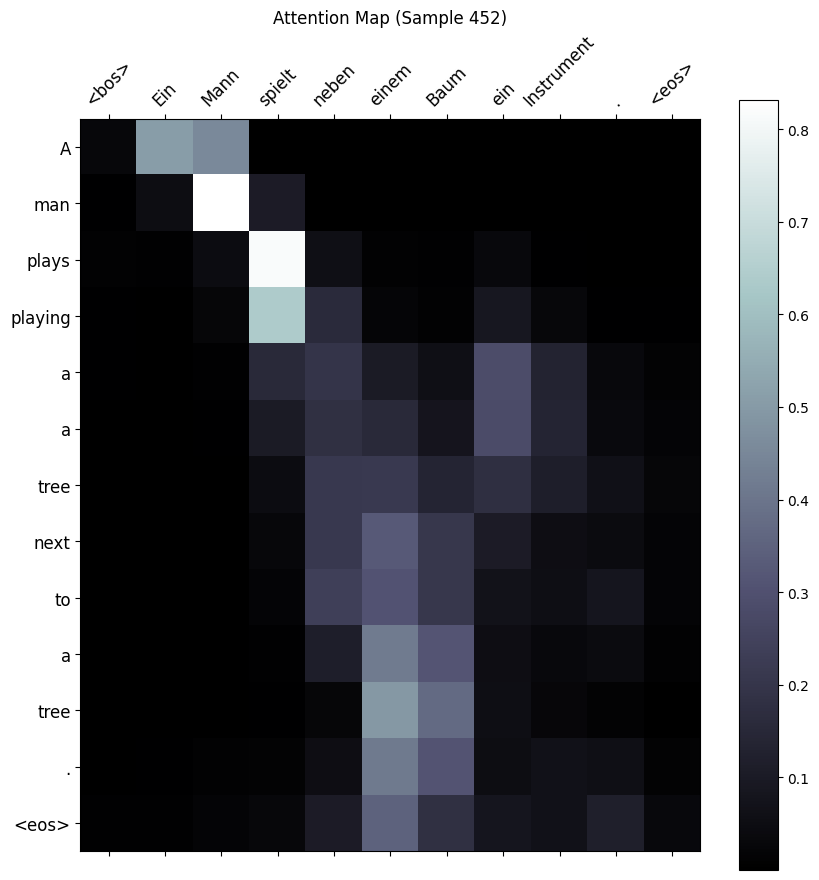


[Sample 959]
Source: Ein Mann mit kariertem Hut in einer schwarzen Jacke und einer schwarz-weiß gestreiften Hose spielt auf einer Bühne mit einem Sänger und einem weiteren Gitarristen im Hintergrund auf einer E-Gitarre.
Target: A man in a black jacket and checkered hat wearing black and white striped pants plays an electric guitar on a stage with a singer and another guitar player in the background.
Model:  A man in a plaid hat and a black jacket and black pants and a black striped striped shirt is playing a guitar on a stage with a guitar on a guitar on a guitar . <eos>


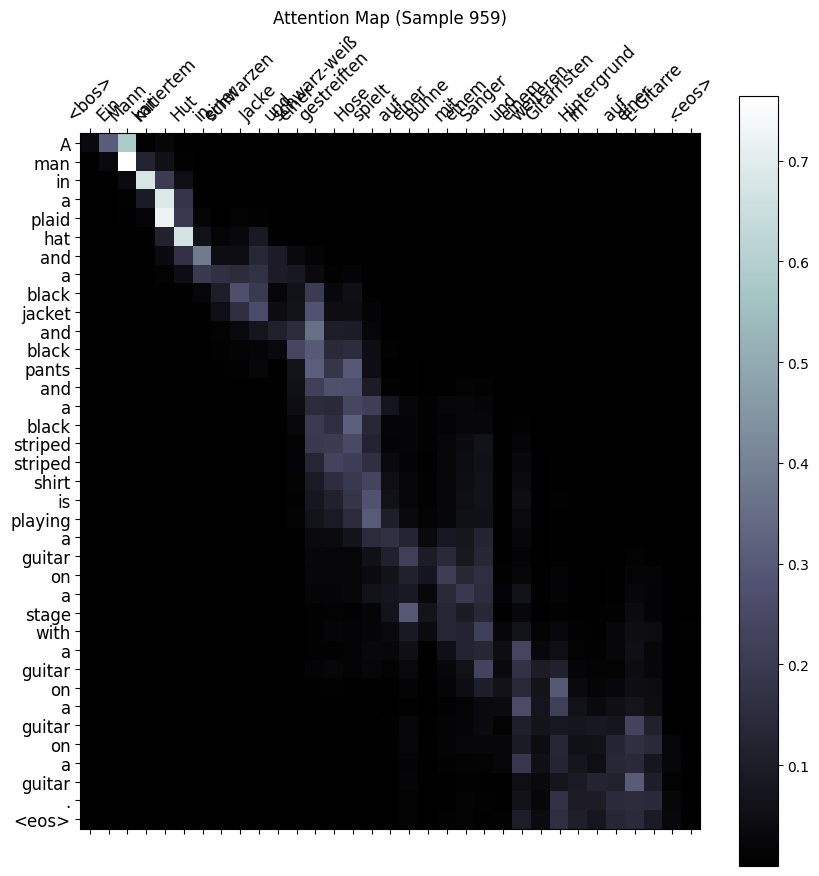


[Sample 451]
Source: Eine afrikanische Familie steht vor ein paar provisorischen Behausungen.
Target: An african family are standing in front of some makeshift houses.
Model:  A group of family is standing in front of some sort of <unk> . <eos>


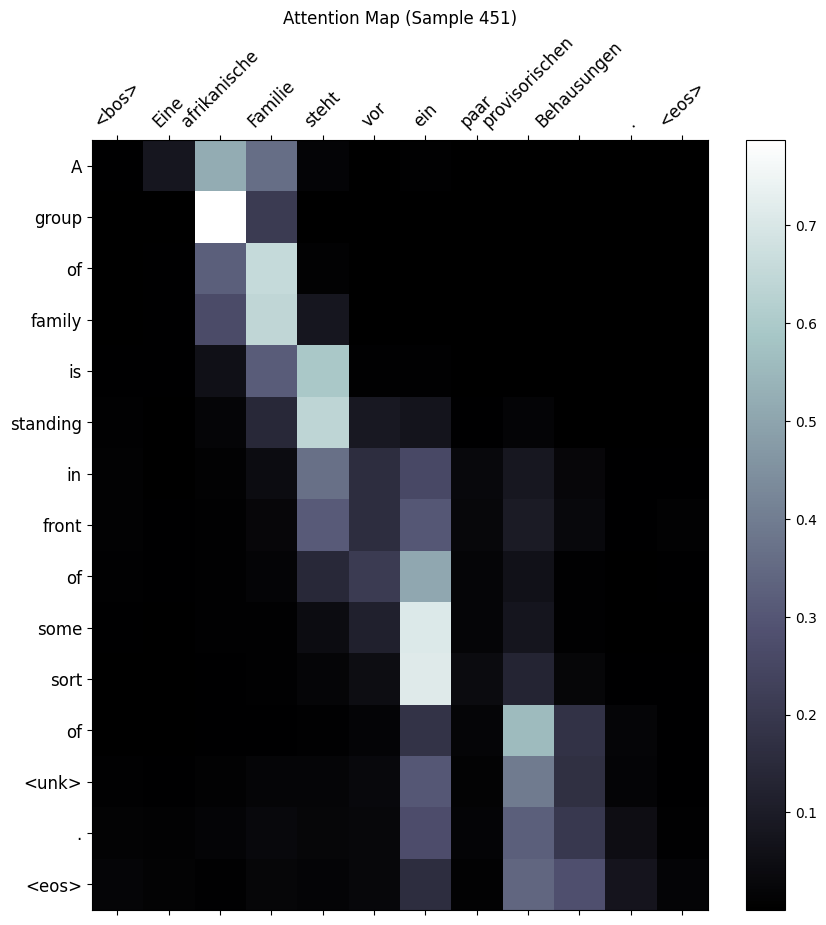


[Sample 716]
Source: Bauarbeiter streiken gegen PM Construction Services.
Target: Construction workers picketing against PM Construction Services.
Model:  Construction workers <unk> <unk> <unk> <unk> <unk> <unk> . <eos>


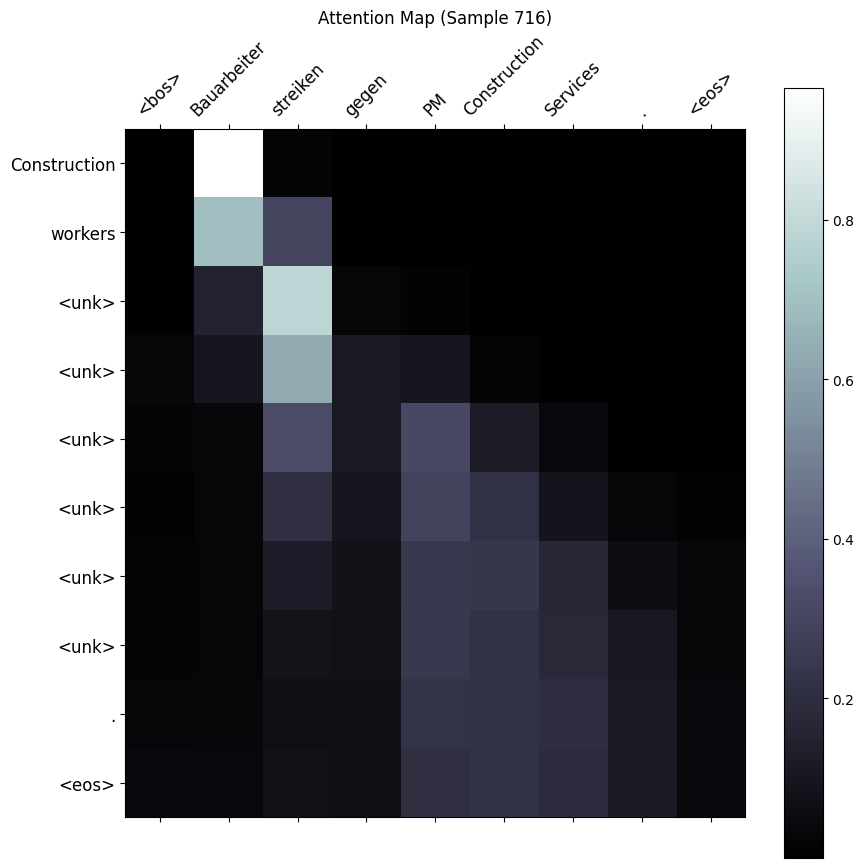


[Sample 651]
Source: Personen stehen um Räucherstäbchen herum und wedeln sich den Rauch ins Gesicht.
Target: People standing around incense, wafting the smoke into their faces.
Model:  People are around around and <unk> and the the the . <eos>


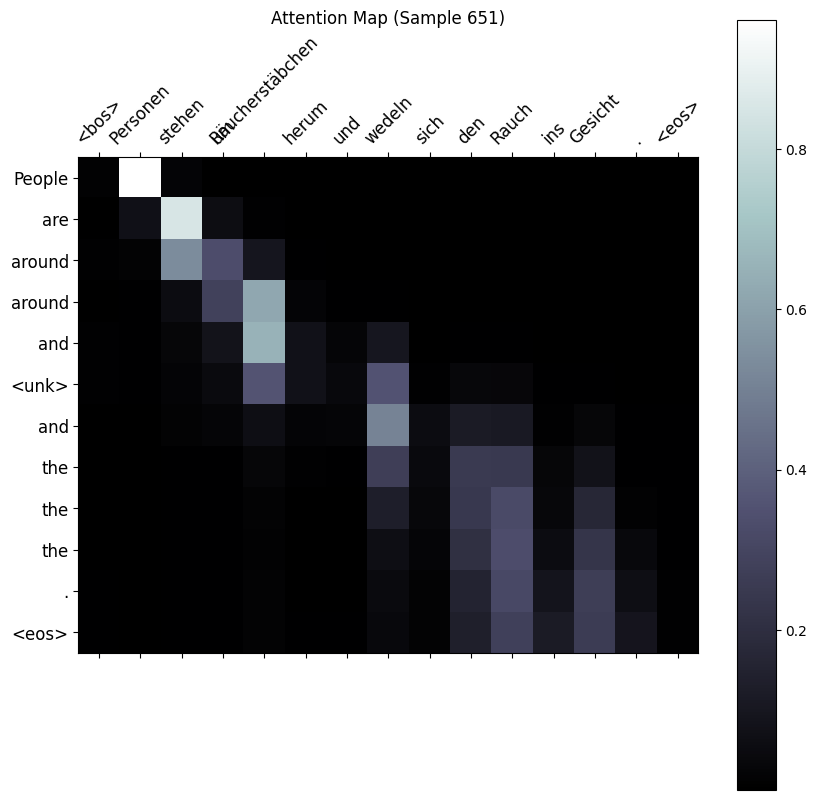

In [11]:
# --- STEP 10: Visualization ---
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

def display_attention(sentence, translation, attention, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    # Handle dimensions (batch first vs seq first)
    if len(attention.shape) == 3:
        attention = attention.squeeze(1) # [trg_len, src_len]
        
    attention = attention.cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)
    ax.tick_params(labelsize=12)
    

    if isinstance(sentence, str):
        # For Spacy/String inputs
        src_tokens = ['<bos>'] + [t for t in tokenizer_de(sentence)] + ['<eos>']
    else:
        # For BERT/Id inputs 
        src_tokens = ['<bos>'] + sentence + ['<eos>']


    trg_tokens = [''] + translation
    

    try:
        ax.set_xticklabels([''] + src_tokens, rotation=45)
        ax.set_yticklabels(trg_tokens)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    except:
        print(" Note: Ticks not set due to length mismatch (visual only).")
    
    plt.title(title)
    plt.show()

print("--- Generating 5 UNIQUE Attention Maps ---")

# FIX: Use random.sample to get unique indices without replacement
unique_indices = random.sample(range(len(test_data)), 5)

for i, idx in enumerate(unique_indices):
    src = test_data[idx]['de']
    trg = test_data[idx]['en']
    
    print(f"\n[Sample {idx}]")
    print(f"Source: {src}")
    print(f"Target: {trg}")
    

    try:
        # Example for Q2 (RNN):
        model_to_viz = model_additive 
        translation, attention = translate_sentence(src, vocab_src, vocab_tgt, model_to_viz, device)
        

        
        print(f"Model:  {' '.join(translation)}")
        
        # Only plot if we have attention weights (RNNs return them easily)
        if 'attention' in locals():
             display_attention(src, translation, attention, f"Attention Map (Sample {idx})")
             
    except NameError:
        print(" Model not found in memory. Make sure you ran the training/loading cell.")
    except Exception as e:
        print(f" Could not visualize: {e}")

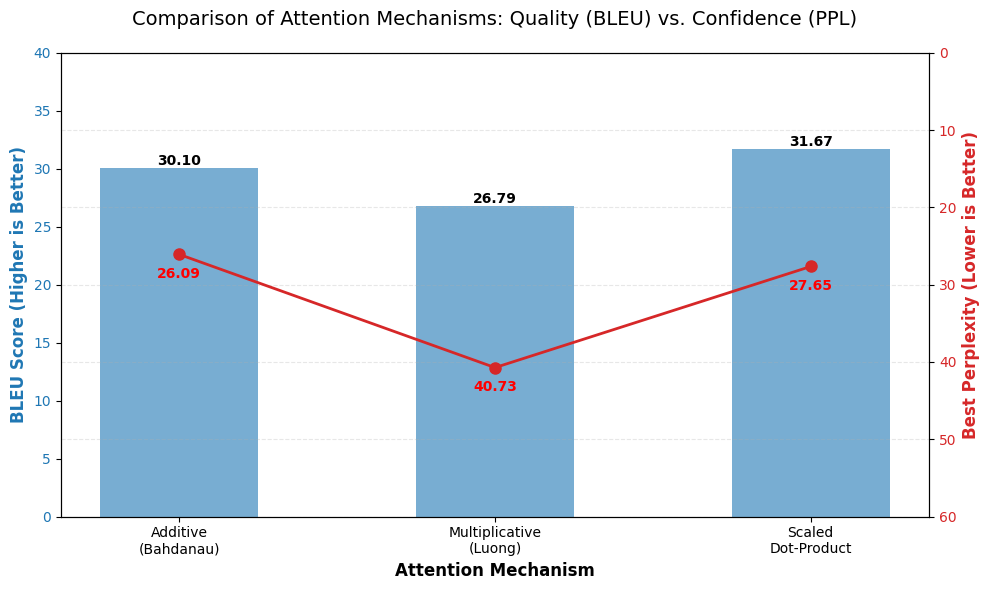

In [12]:
# --- STEP 11: Visualize Q2 Results (BLEU vs PPL) ---
import matplotlib.pyplot as plt
import numpy as np

# Data from our experiments
models = ['Additive\n(Bahdanau)', 'Multiplicative\n(Luong)', 'Scaled\nDot-Product']
bleu_scores = [30.10, 26.79, 31.67]  # From Step 9
best_ppls = [26.09, 40.73, 27.65]    # From Training Logs (Best Val PPL)

# Setup the chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar Chart for BLEU (Left Axis)
color = 'tab:blue'
ax1.set_xlabel('Attention Mechanism', fontsize=12, fontweight='bold')
ax1.set_ylabel('BLEU Score (Higher is Better)', color=color, fontsize=12, fontweight='bold')
bars = ax1.bar(models, bleu_scores, color=color, alpha=0.6, width=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 40)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', color='black', fontweight='bold')

# Line Chart for PPL (Right Axis)
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Best Perplexity (Lower is Better)', color=color, fontsize=12, fontweight='bold')
line = ax2.plot(models, best_ppls, color=color, marker='o', linestyle='-', linewidth=2, markersize=8, label='Perplexity')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 60)
ax2.invert_yaxis() # Invert because Lower PPL is better

# Add value labels for points
for i, ppl in enumerate(best_ppls):
    ax2.text(i, ppl + 3, f'{ppl:.2f}', color='red', ha='center', fontweight='bold')

# Title and Layout
plt.title('Comparison of Attention Mechanisms: Quality (BLEU) vs. Confidence (PPL)', fontsize=14, pad=20)
fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Show the plot
plt.show()

In [18]:
# --- STEP 12---

print("Installing evaluation libraries...")
!pip install evaluate rouge_score > /dev/null

import torch
import torch.nn as nn
import math
import evaluate
from torchtext.data.metrics import bleu_score


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, method="additive"):
        super().__init__()
        self.method = method
        if method == "additive":
            self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
            self.v = nn.Linear(dec_hid_dim, 1, bias=False)
        elif method == "multiplicative":
            self.attn = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        elif method == "dot":
            if (enc_hid_dim * 2) != dec_hid_dim:
                self.project = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
            else: self.project = None

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        attention = None
        if self.method == "additive":
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = torch.tanh(self.attn(combined))
            attention = self.v(energy).squeeze(2)
        elif self.method == "multiplicative":
            projected_enc = self.attn(encoder_outputs)
            hidden_usq = hidden.unsqueeze(1)
            score = torch.bmm(hidden_usq, projected_enc.permute(0, 2, 1))
            attention = score.squeeze(1)
        elif self.method == "dot":
            if hasattr(self, 'project') and self.project is not None:
                encoder_outputs = self.project(encoder_outputs)
            hidden_usq = hidden.unsqueeze(1)
            score = torch.bmm(hidden_usq, encoder_outputs.permute(0, 2, 1))
            d_k = encoder_outputs.shape[-1]
            attention = score.squeeze(1) / (d_k ** 0.5)
        return torch.nn.functional.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        prediction = self.fc_out(torch.cat((output.squeeze(0), weighted.squeeze(0), embedded.squeeze(0)), dim=1))
        return prediction, hidden.squeeze(0)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = (torch.rand(1).item() < teacher_forcing_ratio)
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

# Helpers
def init_model(method):
    attn = Attention(512, 512, method=method)
    enc = Encoder(len(vocab_src), 256, 512, 512, 0.5)
    dec = Decoder(len(vocab_tgt), 256, 512, 512, 0.5, attn)
    return Seq2Seq(enc, dec, device).to(device)

def evaluate_loss(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            output = model(src, trg, 0) # Turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def translate_sentence(sentence, model, device, max_len=50):
    model.eval()
    if isinstance(sentence, str): tokens = [token for token in tokenizer_de(sentence)]
    else: tokens = sentence
    src_indexes = [vocab_src[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    trg_indexes = [vocab_tgt['<bos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == vocab_tgt['<eos>']: break
    trg_tokens = [vocab_tgt.lookup_token(i) for i in trg_indexes]
    return trg_tokens[1:]

# Main Evaluation Loop
rouge_metric = evaluate.load("rouge")
criterion = nn.CrossEntropyLoss(ignore_index=vocab_tgt['<pad>'])

models_to_test = ["additive", "multiplicative", "dot"]
print(f"\n--- 📊 Final Evaluation (Question 2) ---")

for method in models_to_test:
    print(f"\nEvaluating {method.upper()} Attention...")
    try:
        # Load Model
        model = init_model(method)
        model.load_state_dict(torch.load(f'model_{method}.pt'))
        
        # 1. Calculate Perplexity (PPL) on Test Set
        test_loss = evaluate_loss(model, test_dataloader, criterion)
        test_ppl = math.exp(test_loss)
        
        # 2. Calculate BLEU & ROUGE
        trgs, pred_trgs = [], []
        # Only check first 500 samples to save time (sufficient for estimation)
        limit = 500 
        for i, datum in enumerate(test_data[:limit]):
            src, trg = datum['de'], datum['en']
            pred_tokens = translate_sentence(src, model, device)
            
            pred_clean = [t for t in pred_tokens if t not in ('<bos>', '<eos>')]
            pred_str = " ".join(pred_clean)
            
            pred_trgs.append(pred_str)
            trgs.append([trg]) # Nested list for BLEU
            
        # BLEU (Needs tokens)
        bleu_preds = [p.split() for p in pred_trgs]
        bleu_trgs = [[t[0].split()] for t in trgs]
        bleu = bleu_score(bleu_preds, bleu_trgs) * 100
        
        # ROUGE (Needs strings)
        # Flatten trgs for ROUGE: [['sent']] -> ['sent']
        rouge_trgs = [t[0] for t in trgs]
        rouge_res = rouge_metric.compute(predictions=pred_trgs, references=rouge_trgs)
        
        print(f"   >> Test PPL: {test_ppl:.2f}")
        print(f"   >> BLEU:     {bleu:.2f}")
        print(f"   >> ROUGE-L:  {rouge_res['rougeL'] * 100:.2f}")
        
    except Exception as e:
        print(f"   ❌ Error evaluating {method}: {e}")

print("\n✅ Q2 Evaluation Complete.")

Installing evaluation libraries...

--- 📊 Final Evaluation (Question 2) ---

Evaluating ADDITIVE Attention...
   >> Test PPL: 27.49
   >> BLEU:     11.61
   >> ROUGE-L:  45.23

Evaluating MULTIPLICATIVE Attention...
   >> Test PPL: 38.55
   >> BLEU:     8.73
   >> ROUGE-L:  38.21

Evaluating DOT Attention...
   >> Test PPL: 27.68
   >> BLEU:     14.40
   >> ROUGE-L:  50.44

✅ Q2 Evaluation Complete.
